In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

In [25]:
def load_images_from_folder(folder_path, image_size=(64, 64)):
    images = []
    for filename in os.listdir(folder_path):
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(folder_path, filename),
            target_size=image_size
        )
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
        images.append(img)
    return np.array(images)

In [26]:
train_images = load_images_from_folder('C://Users//pajag//OneDrive//Desktop//img apple & tomato//train//tomatoes')

In [27]:
generator = models.Sequential([
    layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Reshape((8, 8, 256)),

    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

In [28]:
discriminator = models.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1)
])

In [36]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [38]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
BATCH_SIZE = 32
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images)).batch(BATCH_SIZE)

In [32]:
train_dataset

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>

In [43]:
EPOCHS = 50

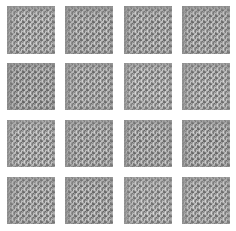

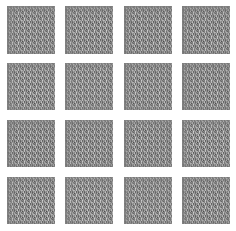

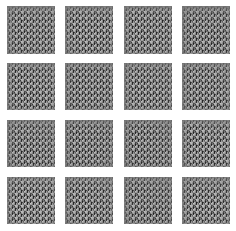

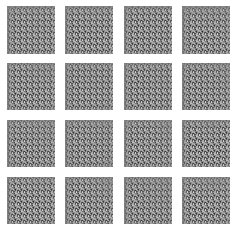

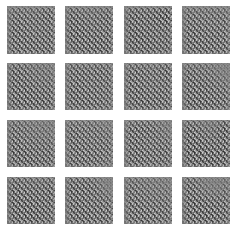

In [44]:
for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(image_batch, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    if epoch % 10 == 0:
        predictions = generator(seed, training=False)

        plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()